In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics



%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# TODO: Use python PathLib to use 
DATA_PATH = '../data/'

### Utils

Functions to add date components as columns, converts a series to a supervised machine learning problem, split train and test, rmse, smape and printing scores of models

In [116]:
import math 
import re


# From fast.ai 0.7
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    df = df.copy()
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
    return df
        
        
def timeseries_to_supervised(df, lag=1, dropnan=True):
    
    df = pd.DataFrame(df)
    columns = [df.shift(i).rename(columns=lambda x: f"{x}(-{i})") for i in range(1, lag+1)]
    columns.insert(0, df)
    df = pd.concat(columns, axis=1)
    
    if dropnan:
        df.dropna(inplace=True)
    else:
        df = df[lag:] #skip nan at the start
        df.fillna(-1, inplace=True)
        
    return df


def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

def smape(predicted, actual):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))


## Load merged air quality and 

In [220]:
## Load 

donggaocun_df = pd.read_feather(DATA_PATH + 'interim/aq_station_merged/donggaocun_aq_merged_weather.feather')

In [6]:
donggaocun_df.iloc[9996:, :]

,utc_datetime,PM2.5,PM10,NO2,CO,O3,SO2,beijing_grid_452_temperature,beijing_grid_452_pressure,beijing_grid_452_humidity,...,beijing_grid_473_pressure,beijing_grid_473_humidity,beijing_grid_473_wind_direction,beijing_grid_473_wind_speed,pinggu_meo_temperature,pinggu_meo_pressure,pinggu_meo_humidity,pinggu_meo_wind_direction,pinggu_meo_wind_speed,pinggu_meo_weather
9996,2018-03-23 04:00:00,NaN,NaN,54.0,1.0,90.0,NaN,15.77,997.58,26.80,...,992.02,27.78,343.55,5.01,17.2,1009.8,30.0,226.0,3.2,Hail
9997,2018-03-23 05:00:00,96.0,NaN,55.0,1.0,88.0,NaN,16.87,997.40,24.64,...,991.87,25.63,328.21,6.09,18.9,1009.3,25.0,216.0,3.8,Hail
9998,2018-03-23 06:00:00,85.0,NaN,26.0,0.6,101.0,6.0,17.98,997.22,22.47,...,991.71,23.47,318.00,7.47,20.8,1008.6,17.0,0.0,3.1,Sunny/clear
9999,2018-03-23 07:00:00,34.0,54.0,15.0,0.3,98.0,13.0,18.25,997.42,22.65,...,991.92,23.82,312.64,6.19,21.6,1008.5,17.0,272.0,2.7,Sunny/clear
10000,2018-03-23 08:00:00,8.0,37.0,9.0,0.2,97.0,10.0,18.53,997.61,22.82,...,992.13,24.16,304.58,4.98,21.7,1008.5,15.0,36.0,1.3,Sunny/clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,2018-03-27 01:00:00,180.0,NaN,49.0,1.3,61.0,25.0,16.84,991.35,37.27,...,985.98,38.25,116.12,5.99,17.3,1004.6,53.0,85.0,3.0,Hail
10090,2018-03-27 02:00:00,184.0,NaN,49.0,1.3,70.0,27.0,18.82,990.69,34.91,...,985.34,35.73,140.61,7.09,19.1,1004.1,51.0,99.0,2.4,Hail
10091,2018-03-27 03:00:00,176.0,NaN,44.0,1.2,89.0,28.0,20.81,990.03,32.55,...,984.70,33.21,156.48,9.08,21.0,1003.4,46.0,133.0,1.8,Hail
10092,2018-03-27 04:00:00,190.0,NaN,36.0,1.0,112.0,25.0,22.65,989.23,28.55,...,983.92,29.18,186.78,8.92,22.0,1002.2,43.0,212.0,1.6,Hail


In [7]:
donggaocun_df.head()

,utc_datetime,PM2.5,PM10,NO2,CO,O3,SO2,beijing_grid_452_temperature,beijing_grid_452_pressure,beijing_grid_452_humidity,...,beijing_grid_473_pressure,beijing_grid_473_humidity,beijing_grid_473_wind_direction,beijing_grid_473_wind_speed,pinggu_meo_temperature,pinggu_meo_pressure,pinggu_meo_humidity,pinggu_meo_wind_direction,pinggu_meo_wind_speed,pinggu_meo_weather
0,2017-01-30 16:00:00,57.0,NaN,10.0,0.7,54.0,14.0,-6.17,1015.44,14.58,...,1009.54,14.25,238.28,3.94,-6.0,1029.0,29.0,114.0,1.0,Haze
1,2017-01-30 17:00:00,61.0,NaN,10.0,0.7,47.0,15.0,-6.35,1015.06,15.41,...,1009.16,15.10,245.46,3.60,-6.0,1028.6,31.0,83.0,1.4,Haze
2,2017-01-30 18:00:00,67.0,NaN,6.0,0.7,43.0,13.0,-6.53,1014.68,16.24,...,1008.77,15.96,253.96,3.33,-6.1,1028.4,34.0,97.0,1.0,Haze
3,2017-01-30 19:00:00,74.0,NaN,7.0,0.9,42.0,13.0,-6.96,1014.20,17.12,...,1008.29,16.79,257.55,3.35,-6.3,1027.7,36.0,82.0,1.2,Haze
4,2017-01-30 20:00:00,69.0,NaN,8.0,0.9,43.0,15.0,-7.39,1013.72,18.00,...,1007.80,17.63,261.07,3.39,-6.0,1026.7,35.0,90.0,1.1,Sunny/clear


## Checking missing data

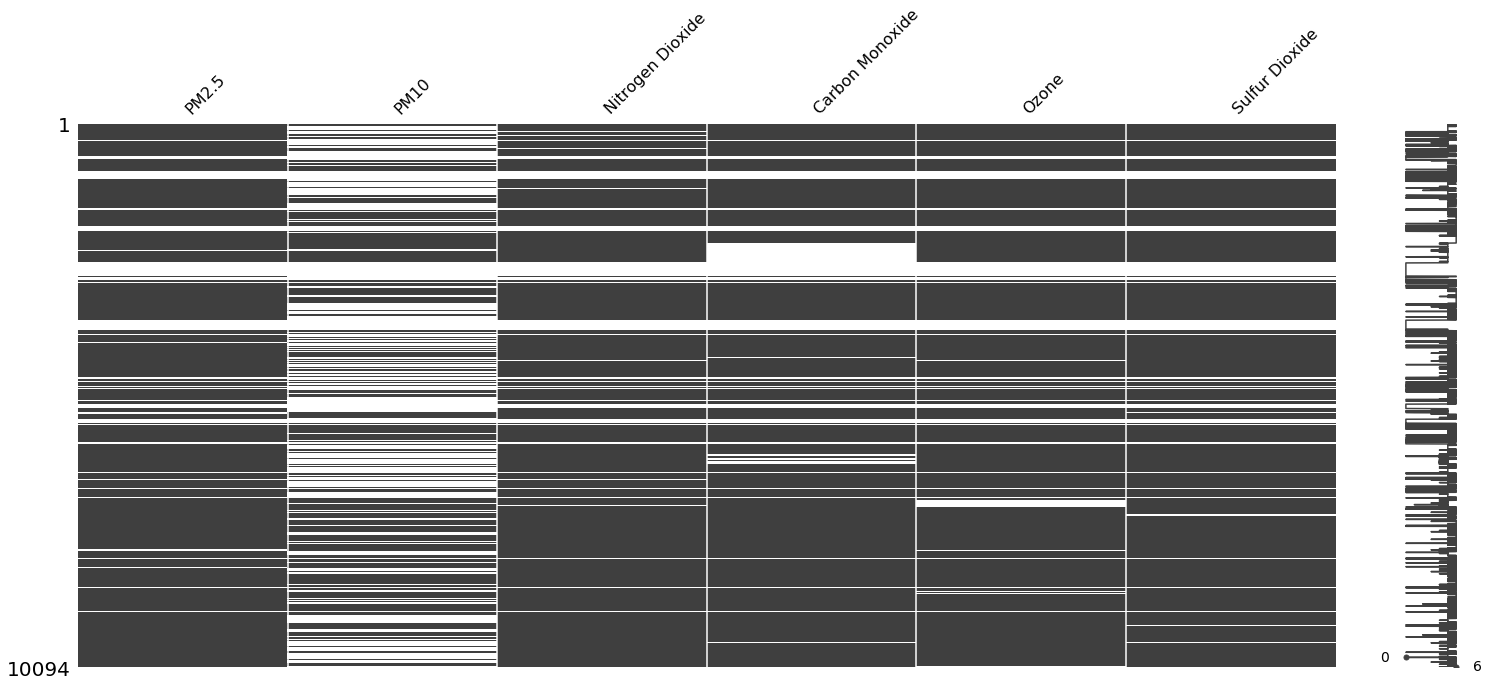

In [112]:
aq_missing_data = donggaocun_df[['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']].copy()
aq_missing_data = aq_missing_data.rename(columns={'NO2': 'Nitrogen Dioxide', 'CO': 'Carbon Monoxide', 'O3': 'Ozone', 'SO2': 'Sulfur Dioxide'})
msno.matrix(aq_missing_data)

In [104]:
huairou = pd.read_feather(DATA_PATH + 'interim/aq_station_merged/huairou_aq_merged_weather.feather')

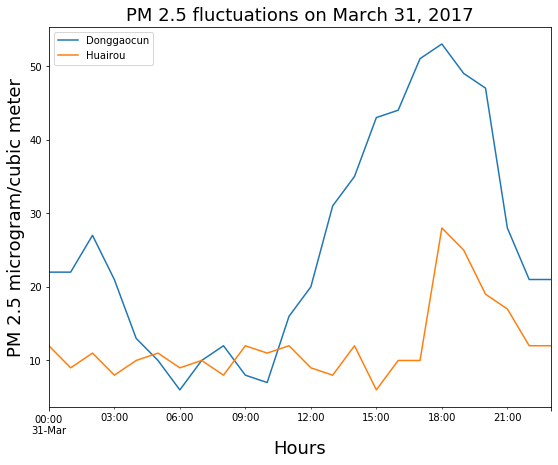

In [111]:
fig, ax = plt.subplots(figsize=(9, 7))
donggaocun_df.set_index('utc_datetime')['PM2.5'].loc['March 31, 2017'].plot(ax=ax, label='Donggaocun')
other_aq.set_index('utc_datetime')['PM2.5'].loc['March 31, 2017'].plot(ax=ax, label='Huairou')
ax.set_title('PM 2.5 fluctuations on March 31, 2017',  fontsize=18)
ax.set_xlabel('Hours',  fontsize=18)
ax.set_ylabel('PM 2.5 microgram/cubic meter',  fontsize=18)
ax.legend(loc='best')
fig.savefig('PM25_day.png')

## Imputer

In [9]:
from fancyimpute import KNN
from fancyimpute import IterativeImputer


def impute_values(df, imputer=None, columns_to_impute=None):
    
    if imputer and (columns_to_impute is not None):
            df_remaining = df.drop(columns_to_impute, axis=1)
            df_to_impute = df[columns_to_impute]
            imputed_values = imputer.fit_transform(df_to_impute)
            df_imputed = pd.DataFrame(imputed_values, columns=columns_to_impute, index=df_remaining.index)
            df = pd.concat([df_remaining, df_imputed], axis=1)
    return df
    

Using TensorFlow backend.
/Users/mjjim2003/Documents/Eskwelabs/Capstone_Project/Air_Quality/KDD_Air_Quality/kdd_air_quality/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mjjim2003/Documents/Eskwelabs/Capstone_Project/Air_Quality/KDD_Air_Quality/kdd_air_quality/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mjjim2003/Documents/Eskwelabs/Capstone_Project/Air_Quality/KDD_Air_Quality/kdd_air_quality/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1)

In [10]:
columns_to_impute = donggaocun_df.columns[donggaocun_df.columns.str.contains('meo|grid')]
columns_to_impute = columns_to_impute[~columns_to_impute.str.contains('weather')]

In [11]:
imputed_df = impute_values(donggaocun_df, KNN(5), columns_to_impute)

Imputing row 1/10094 with 0 missing, elapsed time: 17.928
Imputing row 101/10094 with 0 missing, elapsed time: 17.928
Imputing row 201/10094 with 0 missing, elapsed time: 17.930
Imputing row 301/10094 with 0 missing, elapsed time: 17.931
Imputing row 401/10094 with 0 missing, elapsed time: 17.932
Imputing row 501/10094 with 0 missing, elapsed time: 17.932
Imputing row 601/10094 with 0 missing, elapsed time: 17.933
Imputing row 701/10094 with 0 missing, elapsed time: 17.934
Imputing row 801/10094 with 0 missing, elapsed time: 17.934
Imputing row 901/10094 with 15 missing, elapsed time: 17.935
Imputing row 1001/10094 with 15 missing, elapsed time: 17.941
Imputing row 1101/10094 with 0 missing, elapsed time: 17.945
Imputing row 1201/10094 with 0 missing, elapsed time: 17.945
Imputing row 1301/10094 with 0 missing, elapsed time: 17.946
Imputing row 1401/10094 with 0 missing, elapsed time: 17.947
Imputing row 1501/10094 with 0 missing, elapsed time: 17.947
Imputing row 1601/10094 with 0 mis

## Add datetime components and dummy weather features

In [12]:
processed_df = pd.get_dummies(imputed_df)

In [13]:
add_datepart(processed_df, fldname='utc_datetime',drop=False, time=True)

,utc_datetime,PM2.5,PM10,NO2,CO,O3,SO2,beijing_grid_452_temperature,beijing_grid_452_pressure,beijing_grid_452_humidity,...,utc_datetimeIs_month_end,utc_datetimeIs_month_start,utc_datetimeIs_quarter_end,utc_datetimeIs_quarter_start,utc_datetimeIs_year_end,utc_datetimeIs_year_start,utc_datetimeHour,utc_datetimeMinute,utc_datetimeSecond,utc_datetimeElapsed
0,2017-01-30 16:00:00,57.0,NaN,10.0,0.7,54.0,14.0,-6.17,1015.44,14.58,...,False,False,False,False,False,False,16,0,0,1485792000
1,2017-01-30 17:00:00,61.0,NaN,10.0,0.7,47.0,15.0,-6.35,1015.06,15.41,...,False,False,False,False,False,False,17,0,0,1485795600
2,2017-01-30 18:00:00,67.0,NaN,6.0,0.7,43.0,13.0,-6.53,1014.68,16.24,...,False,False,False,False,False,False,18,0,0,1485799200
3,2017-01-30 19:00:00,74.0,NaN,7.0,0.9,42.0,13.0,-6.96,1014.20,17.12,...,False,False,False,False,False,False,19,0,0,1485802800
4,2017-01-30 20:00:00,69.0,NaN,8.0,0.9,43.0,15.0,-7.39,1013.72,18.00,...,False,False,False,False,False,False,20,0,0,1485806400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,2018-03-27 01:00:00,180.0,NaN,49.0,1.3,61.0,25.0,16.84,991.35,37.27,...,False,False,False,False,False,False,1,0,0,1522112400
10090,2018-03-27 02:00:00,184.0,NaN,49.0,1.3,70.0,27.0,18.82,990.69,34.91,...,False,False,False,False,False,False,2,0,0,1522116000
10091,2018-03-27 03:00:00,176.0,NaN,44.0,1.2,89.0,28.0,20.81,990.03,32.55,...,False,False,False,False,False,False,3,0,0,1522119600
10092,2018-03-27 04:00:00,190.0,NaN,36.0,1.0,112.0,25.0,22.65,989.23,28.55,...,False,False,False,False,False,False,4,0,0,1522123200


In [223]:
pd.read_feather(DATA_PATH + 'processed/donggaocun_processed.feather').columns

Index(['utc_datetime', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2',
       'pinggu_meo_weather', 'beijing_grid_452_temperature',
       'beijing_grid_452_pressure', 'beijing_grid_452_humidity',
       'beijing_grid_452_wind_direction', 'beijing_grid_452_wind_speed',
       'beijing_grid_473_temperature', 'beijing_grid_473_pressure',
       'beijing_grid_473_humidity', 'beijing_grid_473_wind_direction',
       'beijing_grid_473_wind_speed', 'pinggu_meo_temperature',
       'pinggu_meo_pressure', 'pinggu_meo_humidity',
       'pinggu_meo_wind_direction', 'pinggu_meo_wind_speed',
       'utc_datetimeYear', 'utc_datetimeMonth', 'utc_datetimeWeek',
       'utc_datetimeDay', 'utc_datetimeDayofweek', 'utc_datetimeDayofyear',
       'utc_datetimeIs_month_end', 'utc_datetimeIs_month_start',
       'utc_datetimeIs_quarter_end', 'utc_datetimeIs_quarter_start',
       'utc_datetimeIs_year_end', 'utc_datetimeIs_year_start',
       'utc_datetimeHour', 'utc_datetimeMinute', 'utc_datetimeSecond',
      

## Generate X_train, y_train, X_valid and y_valid

In [15]:
def generate_train_test_data(df, target_column, split_ratio=None, split_date=None, lag_observations=1, dropnan=True):
    
    supervised_df = timeseries_to_supervised(df, lag_observations, dropnan=dropnan)

    if split_ratio is not None:
        split_index = int(len(supervised_df) * split_ratio)
    elif split_date is not None:
        date_index = supervised_df.index.get_loc(split_date)
        if type(date_index) == slice:
            split_index = date_index.start
        else:
            split_index = date_index
    else:
        raise("Must specify split ratio or split date")
    
    non_lagged_columns = list(supervised_df.columns[~supervised_df.columns.str.contains('\(.*\)')])
    non_lagged_columns.append(target_column)
    X = supervised_df.drop(non_lagged_columns, axis=1)
    y = supervised_df[target_column]
    
    
    X_train, X_valid = split_vals(X, split_index)
    y_train, y_valid = split_vals(y, split_index)
       
    
    return X_train, y_train, X_valid, y_valid
    
    

In [16]:
processed_df.set_index('utc_datetime', inplace=True)

In [19]:
processed_df.reset_index().to_feather(DATA_PATH + f"processed/donggaocun_processed.feather")

In [ ]:
target_column='O3'
X_train, y_train, X_valid, y_valid = generate_train_test_data(processed_df, split_ratio=0.8, target_column=target_column, lag_observations=15, dropnan=True)

## Test initial model

In [ ]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print_score(rf)

## Test optimal number of lagging hours per air pollutant

In [ ]:

def find_optimal_lagging_hours(df, target_column, split_ratio=0.8):
    rmse_results = []
    smape_results = []
    for hours_lagged in range(1, 24):

        X_train, y_train, X_valid, y_valid = generate_train_test_data(df, split_ratio=split_ratio, target_column=target_column, lag_observations=hours_lagged, dropnan=True)        
        
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_valid)
        rmse_results.append(rmse(predictions, y_valid))
        smape_results.append(smape(predictions, y_valid))
    
    return rmse_results, smape_results
    

In [ ]:
pm25_rmse_results, pm25_smape_results = find_optimal_lagging_hours(processed_df, 'PM2.5')

In [ ]:
pd.Series(pm25_rmse_results).sort_values().head()

In [ ]:
pd.Series(pm25_smape_results).sort_values().head()

In [ ]:
pd.Series(pm25_rmse_results).plot()

In [ ]:
pd.Series(pm25_smape_results).plot()

**Select n=16 as number of lagged observations for PM2.5**

In [ ]:
pm10_rmse_results, pm10_smape_results = find_optimal_lagging_hours(processed_df, 'PM10')

In [ ]:
pd.Series(pm10_rmse_results).sort_values().head()

In [ ]:
pd.Series(pm10_rmse_results).sort_values().plot()

In [ ]:
pd.Series(pm10_smape_results).sort_values().min(), pd.Series(pm10_smape_results).sort_values().min()

**Select n=13 as number of lagged observations for PM10. PM10 SMAPE has low variance for lagged observations**

In [ ]:
o3_rmse_results, o3_smape_results = find_optimal_lagging_hours(processed_df, 'O3')

In [ ]:
pd.Series(o3_rmse_results).sort_values().head()

In [ ]:
pd.Series(o3_smape_results).sort_values().head(15)

**Select n=10 as number of lagged observations for O3.**

## Loading and visualizing XGBoost and LightGBM results

In [194]:
pm25_actual = pd.read_csv(DATA_PATH + 'processed/pm25_actual.csv', header=None, index_col=0, squeeze=True)
pm10_actual = pd.read_csv(DATA_PATH + 'processed/pm10_actual.csv', header=None, index_col=0, squeeze=True)
O3_actual = pd.read_csv(DATA_PATH + 'processed/O3_actual.csv', header=None, index_col=0, squeeze=True)

**XGBoost predictions**

In [195]:
pm25_xgb_predictions = np.load(DATA_PATH + 'processed/pm25_xg_predictions.npy')
pm25_xgb_predictions = pd.Series(pm25_xgb_predictions, index=pm25_actual.index)

pm10_xgb_predictions = np.load(DATA_PATH + 'processed/pm10_xg_predictions.npy')
pm10_xgb_predictions = pd.Series(pm10_xgb_predictions, index=pm10_actual.index)

O3_xgb_predictions = np.load(DATA_PATH + 'processed/O3_xg_predictions.npy')
O3_xgb_predictions = pd.Series(O3_xgb_predictions, index=O3_actual.index)

In [197]:
# pm25_actual.index.min(), pm25_actual.index.max()
# pm25_actual.shape
# pd.date_range(pm25_actual.index.min(), pm25_actual.index.max(), freq='H')

DatetimeIndex(['2018-01-02 06:00:00', '2018-01-02 07:00:00',
               '2018-01-02 08:00:00', '2018-01-02 09:00:00',
               '2018-01-02 10:00:00', '2018-01-02 11:00:00',
               '2018-01-02 12:00:00', '2018-01-02 13:00:00',
               '2018-01-02 14:00:00', '2018-01-02 15:00:00',
               ...
               '2018-03-26 20:00:00', '2018-03-26 21:00:00',
               '2018-03-26 22:00:00', '2018-03-26 23:00:00',
               '2018-03-27 00:00:00', '2018-03-27 01:00:00',
               '2018-03-27 02:00:00', '2018-03-27 03:00:00',
               '2018-03-27 04:00:00', '2018-03-27 05:00:00'],
              dtype='datetime64[ns]', length=2016, freq='H')

**Plotting XGBoost predictions vs. Actual values**

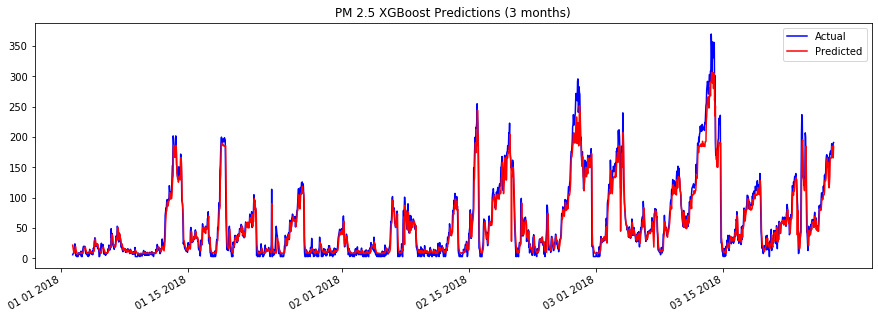

In [218]:
fig, ax = plt.subplots(figsize=(15, 5))

index = pd.to_datetime(pm25_actual.index)

xaxis_formatter = DateFormatter("%m %d %Y")
ax.xaxis.set_major_formatter(xaxis_formatter)


ax.plot(index, pm25_actual, label='Actual', color='blue')
ax.plot(index, pm25_xgb_predictions, label='Predicted', color='red')

ax.set_title('PM 2.5 XGBoost Predictions (3 months)')
ax.legend()

fig.autofmt_xdate()

fig.savefig('pm25_xgb.png')


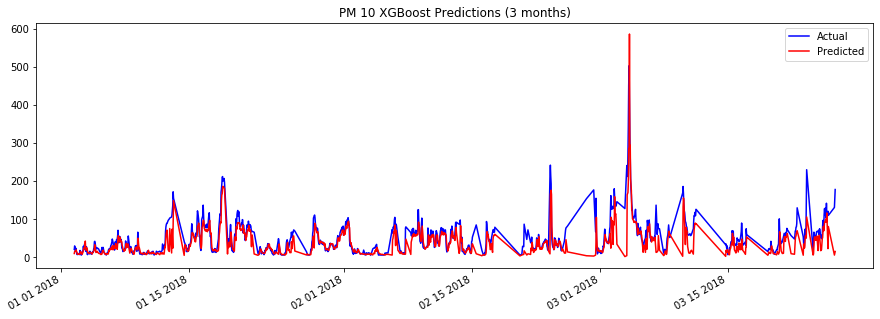

In [219]:

fig, ax = plt.subplots(figsize=(15, 5))

index = pd.to_datetime(pm10_actual.index)

xaxis_formatter = DateFormatter("%m %d %Y")
ax.xaxis.set_major_formatter(xaxis_formatter)


ax.plot(index, pm10_actual, label='Actual', color='blue')
ax.plot(index, pm10_xgb_predictions, label='Predicted', color='red')

ax.set_title('PM 10 XGBoost Predictions (3 months)')
ax.legend()

fig.autofmt_xdate()

fig.savefig('pm10_xgb.png')


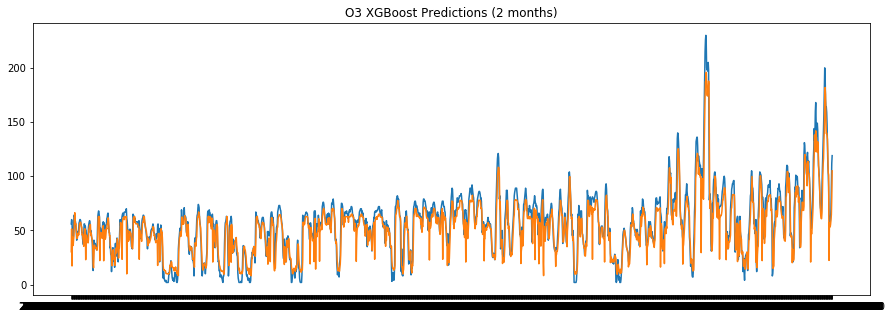

In [215]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(O3_actual, label='O3 Actual')
plt.plot(O3_xgb_predictions, label='Predictions')
ax.set_title('O3 XGBoost Predictions (2 months)')
fig.savefig('O3_xgb.png')

**LightGBM predictions**

In [204]:
pm25_lgb_predictions = np.load(DATA_PATH + 'processed/pm25_lgb_predictions.npy')
pm10_lgb_predictions = np.load(DATA_PATH + 'processed/pm10_lgb_predictions.npy')
O3_lgb_predictions = np.load(DATA_PATH + 'processed/O3_lgb_predictions.npy')

In [151]:
pd.to_datetime(pm25_actual.index)

DatetimeIndex(['2018-01-17 05:00:00', '2018-01-17 06:00:00',
               '2018-01-17 07:00:00', '2018-01-17 08:00:00',
               '2018-01-17 09:00:00', '2018-01-17 10:00:00',
               '2018-01-17 11:00:00', '2018-01-17 12:00:00',
               '2018-01-17 13:00:00', '2018-01-17 14:00:00',
               ...
               '2018-03-01 23:00:00', '2018-03-02 00:00:00',
               '2018-03-02 01:00:00', '2018-03-02 02:00:00',
               '2018-03-02 03:00:00', '2018-03-04 15:00:00',
               '2018-03-04 16:00:00', '2018-03-04 17:00:00',
               '2018-03-04 18:00:00', '2018-03-04 19:00:00'],
              dtype='datetime64[ns]', name=0, length=154, freq=None)

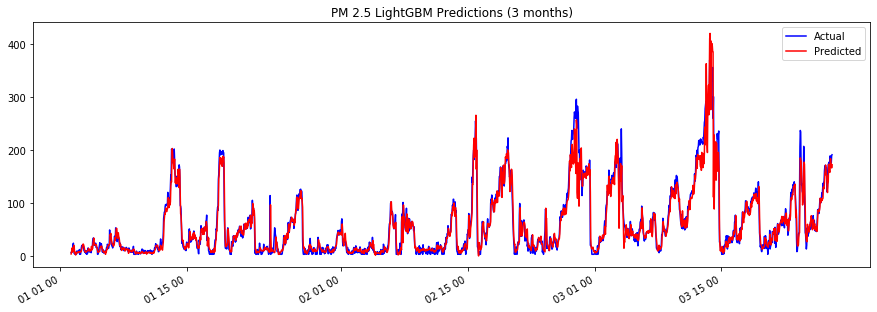

In [213]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15, 5))

index = pd.to_datetime(pm25_actual.index)

xaxis_formatter = DateFormatter("%m %d %H")
ax.xaxis.set_major_formatter(xaxis_formatter)


ax.plot(index, pm25_actual, label='Actual', color='blue')
ax.plot(index, pm25_lgb_predictions, label='Predicted', color='red')

ax.set_title('PM 2.5 LightGBM Predictions (3 months)')
ax.legend()

fig.autofmt_xdate()


fig.savefig('pm25_lgb.png')

In [159]:
pm10_actual

1
1970-01-01 00:00:00.000000054     54.0
1970-01-01 00:00:00.000000060     60.0
1970-01-01 00:00:00.000000025     25.0
1970-01-01 00:00:00.000000019     19.0
1970-01-01 00:00:00.000000015     15.0
                                 ...  
1970-01-01 00:00:00.000000051     51.0
1970-01-01 00:00:00.000000053     53.0
1970-01-01 00:00:00.000000048     48.0
1970-01-01 00:00:00.000000142    142.0
1970-01-01 00:00:00.000000108    108.0
Name: 1, Length: 192, dtype: float64

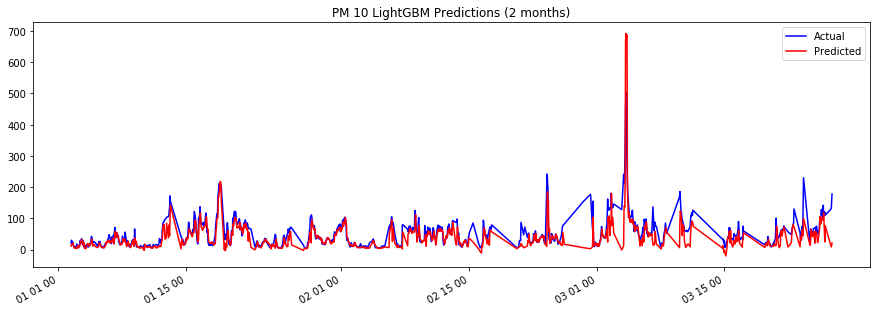

In [214]:
fig, ax = plt.subplots(figsize=(15, 5))

index = pd.to_datetime(pm10_actual.index)

xaxis_formatter = DateFormatter("%m %d %H")
ax.xaxis.set_major_formatter(xaxis_formatter)

ax.plot(index, pm10_actual, label='Actual', color='blue')
ax.plot(index, pm10_lgb_predictions, label='Predicted', color='red')

ax.set_title('PM 10 LightGBM Predictions (2 months)')
ax.legend()

fig.autofmt_xdate()

fig.savefig('pm10_lgb.png')


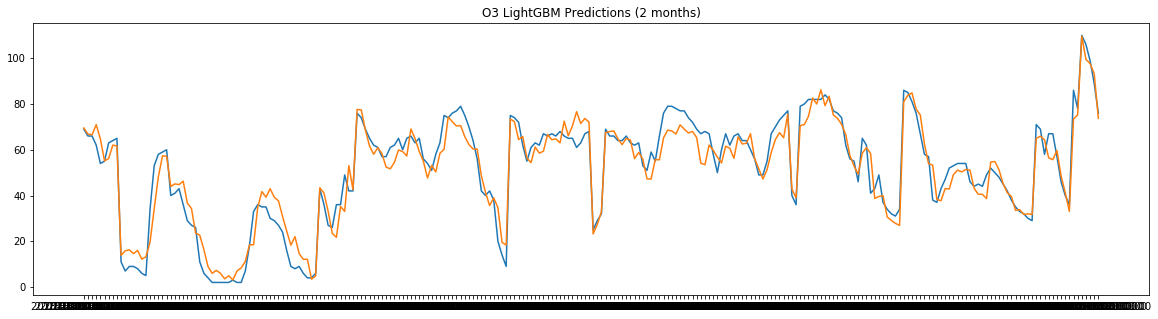

In [71]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.plot(O3_actual)
plt.plot(O3_lgb_predictions)
ax.set_title('O3 LightGBM Predictions (2 months)')
fig.savefig('O3_lgb.png')